In [1]:
import arviz as az
import causalpy as cp
import matplotlib.pyplot as plt
import pandas as pd
import pymc as pm
import seaborn as sns
from joblib import Parallel, delayed

import numpy as np

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [16, 8]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

seed = 42

# Estimating Causal Impacts with CausalPy from PyMC Labs

On July 15, the Major League Soccer (MLS) Club Inter Miami introduced its latest addition: Lionel Messi. The best soccer player in history will play for Miami through the 2025 Major League Soccer season.
Messi’s arrival in Miami is a big deal for Apple’s streaming service. Apple announce its MLS season pass which gives subscribers access to every MLS game. In a recent earnings call, Apple CEO Tim Cook, said that
[Messi has helped increase Apple TV+ subscribers](https://www.businessinsider.com/apple-tv-mls-lionel-messi-tim-cook-mls-soccer-sports-2023-8).

While AppleTV may not have commanded the streaming scene in Argentina, compared to other streaming platforms such as Netflix or Amazon Prime, this could change thanks to Apple's partnership with the MLS.
So, could the incorporation of Messi into the MLS really be a game-changer for the streaming domain in Argentina? To answer this question, we might delve into the past 90 days of Google Trend data, assessing the popularity of the major streaming platforms in Argentina.
Ultimately, our aim is to estimate the causal impact of Messi's incorporation to the MLS on the preferences of streaming platforms in Argentina.

Now imagine you were a Data Scientist working at Apple and you we were given the task of estimating this causal question, how would you approach it?
Well, it is not new to any data scientist that *randomized control trial* (RCT) — also referred to as *online experiments* or *A/B tests* — are the standard rule in the industry to estimate causal effects. In an RCT a random group is exposed to the treatment while the other group stays as the control group, this ensures that any observed difference between the two groups can be due only to the treatment and no other unobserved variable, thus eliminating selection bias.

In RCTs, we have full control over the treatment assignment mechanism. However, many times RCTs are not feasible for being expensive to run, unethical, etc. In such cases, Quasi-experimental Designs come to the rescue, especially when we don't have control over the treatment assignment mechanism. Among the various approaches within quasi-experimental designs, the Synthetic Control method has gained a lot of popularity in the data science community and companies such as [Microsoft](https://medium.com/data-science-at-microsoft/causal-inference-using-synthetic-controls-d96a890c83a7), [Uber](https://www.youtube.com/watch?v=j5DoJV5S2Ao), [Meta](https://research.facebook.com/publications/regression-adjustment-with-synthetic-controls-in-online-experiments/) and [Amazon](https://www.amazon.science/publications/a-self-supervised-approach-to-hierarchical-forecasting-with-applications-to-groupwise-synthetic-controls) are implementing this technique in real-world scenarios.

In this article we will apply Synthetic Control for estimating the causal impact of Messi's entry into the MLS on AppleTV's Google Trends data. We will use other streaming platforms such as Netflix, Amazon Prime, Paramount+, etc as our control group (commonly referred as the *donor pool*). We will explore a Bayesian approach of synthetic controls and implement it using an open source package, [CausalPy](https://causalpy.readthedocs.io/en/latest/), from PyMC Labs.

# The Data

We will use Google Trend data of the last 90 days for our analysis.
*Apple TV+* will be our treated platform, while the platforms chosen as controls include *Disney+*, *Paramount+*, *Netflix*, *hulu*, *HBO*, *YoutubeTV* and *Peacock*.
Our intervention day will be the 15th of July of 2023, the date in which Messi joined the MLS League.

Now lets read the data and plot these time series:

In [2]:
df = (
    pd.read_csv("data/google_trends_data.csv", parse_dates=["index"])
    .set_index("index")
)

In [3]:
control_platforms = [
    "Disney",
    "Paramount",
    "Netflix",
    "hulu",
    "HBO",
    "YoutubeTV",
    "Peacock",
]
target_platform = "AppleTV"
treatment_index = pd.to_datetime("2023-07-15")

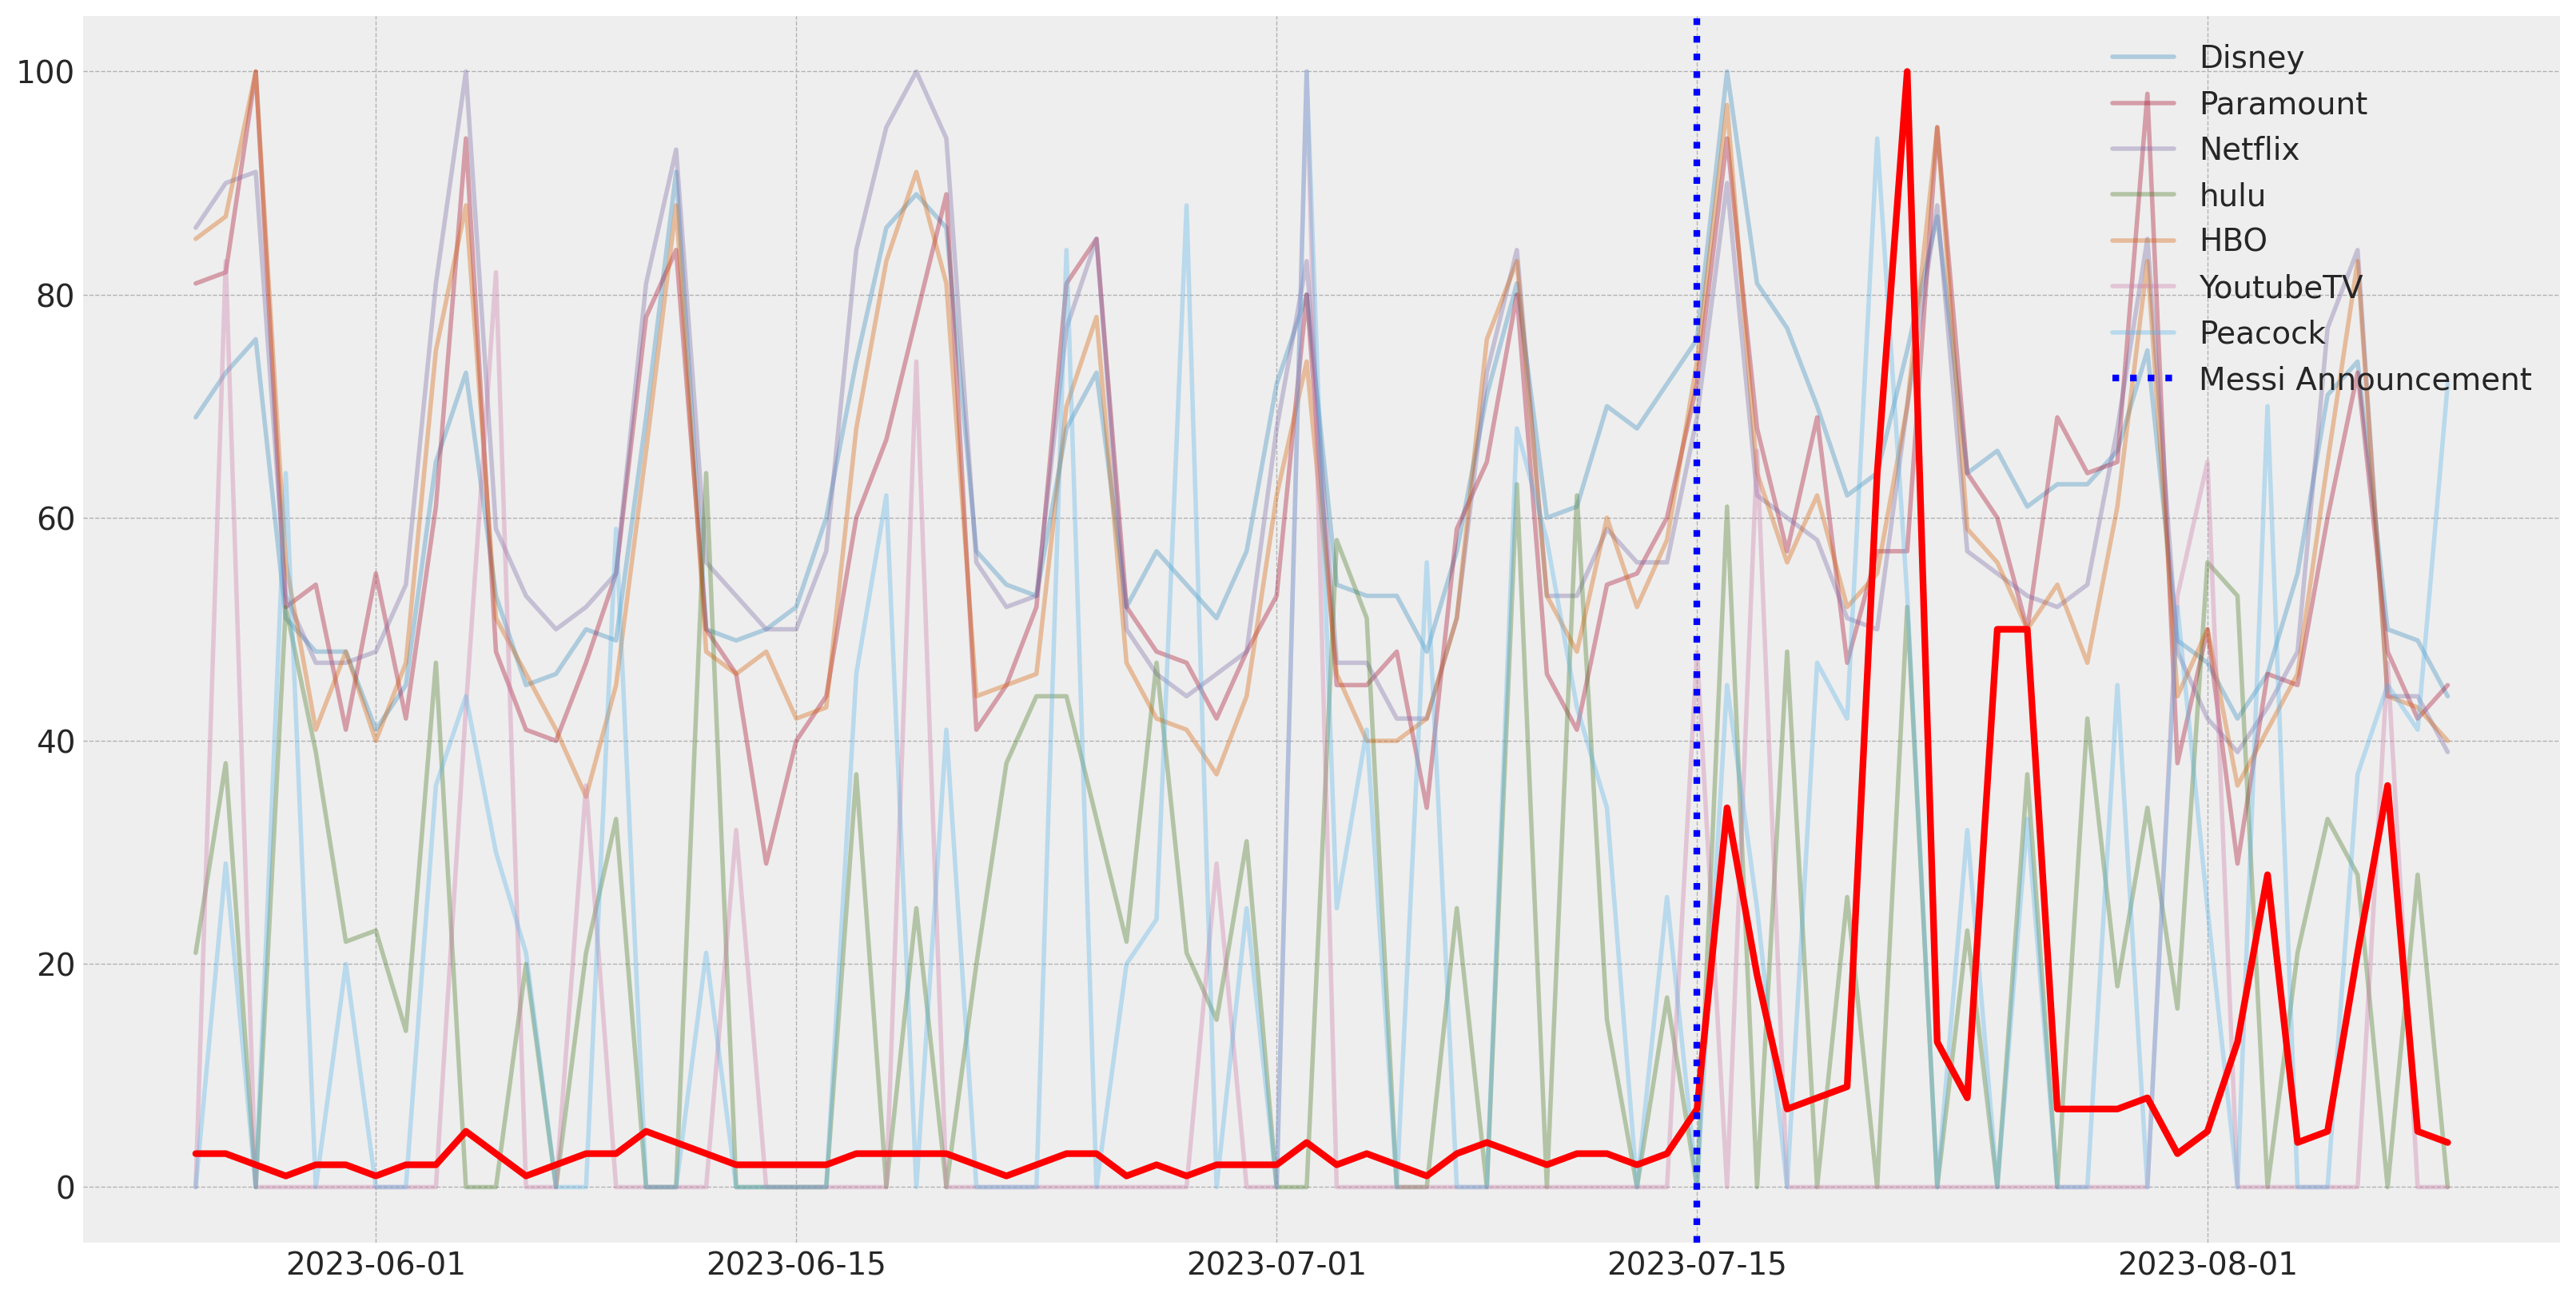

In [4]:
fig, ax = plt.subplots()
for col in control_platforms:
    ax.plot(df.index, df[col], alpha=0.35, label=col)

ax.plot(df.index, df[target_platform], color="red", lw=3)
ax.axvline(x=treatment_index, color="b", ls=":", lw=3, label="Messi Announcement")
ax.legend(loc="upper right");

At first glance, we notice that *AppleTV* google views increase significantly after the treatment. However, the *AppleTV* time series has a lot of fluctuations making it challenging to interpret it. 
Also there is uncertainty about whether the donor variables maintain their historical patterns during the post-treatment period.
Given these complexities, it's difficult to attribute the change in *AppleTV* specifically to the Messi Announcement and even more difficult to quantify this causal effect.

Could we implement Synthetic Controls in order to get a clear estimate of the causal impact?

# Deep Dive into Synthetic Controls

We are trying to estimate what would have happen, in terms of google trends, if the intervention had not taken place. This is a counterfactual question, since we want to compare the actual google trends of *AppleTV* vs what would have been if Messi hadn't joined the MLS.
Although we can't oberserve the counterfactual (this has been named as the [Fundamental Problem of Causal Inference](https://en.wikipedia.org/wiki/Rubin_causal_model#:~:text=The%20Fundamental%20Problem%20of%20Causal%20Inference%20is%20that%20it%20is,to%20estimate%20the%20missing%20counterfactuals)), there are many quasi-experimental methods that can help us to estimate this.
Here, we will use the Synthetic Control estimator to estimate the counterfactual after the intervention period.
As we saw earlier, we have *AppleTV* that is our treated unit, and we have a couple of other control units, often refer to as the *donor pool*. With that said, lets dive deeper into Synthetic Control.

### The Formal Setting

Imagine a scenario where you have $J+1$ distinct units. Assume unit 1 is the one subjected to an intervention while units $j=2,...,J+1$ represent the "donor pool" - a collection of untreated units. These units give us data over 
$T$ time periods, with $T_0$ periods before the actual intervention.

For each unit $j$ and each time $t$, we observe the outcome $Y_{jt}$. In this sense:
- $Y^N_{jt}$ represents the potential outcome without the intervention.
- $Y^I_{jt}$ represents the potential outcome with the intervention.

Thus, the impact of the intervention for the treated unit $j=1$ at time t, for $t>T_0$ is defined as: 

$
\tau_{1t} = Y^I_{jt} - Y^N_{jt}
$

The challenge is that $Y^N_{jt}$ is unobservable.


To tackle this, one can utilize the donor pool.
The motivation of the synthetic control method is that a combination of units in the donor pool may approximate the characteristics of the affected unit substantially better than any unaffected unit alone.
In that sense, a synthetic control is essentially a weighted average of the units in the donor pool. Hence, with the weight vector $\pmb{W}=(w_2, ..., w_{J+1})$, the synthetic control estimate of $Y^N_{jt}$ becomes:

$
\hat{Y}^N_{jt} = \sum^{J+1}_{j=2} w_j Y_{jt}
$ 

### Choosing the Right Weights

So far we have a problem: **negative weights**.
The above formula could led into some weights been negative, thus meaning that some control units contribute negatively to the prediction. 
Since we would like to interpret our synthetic control as a weighted average of untreated platforms, all weights should be positive and they should sum to one. To adress this concern, [Abadie, Diamond, and Hainmueller (2010)](https://www.tandfonline.com/doi/abs/10.1198/jasa.2009.ap08746) propose that weights are restricted to be nonnegative and to sum to one.


If your are interested on a more intuitive explanation of this checkout [Chapter 15 of Matheus Facure online book.](https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html#don-t-extrapolate)
One thing to notice is that restricting synthetic control weights to be nonnegative and sum to one generates weights that are typically sparse. That is, only a small number of units in the donor pool contribute to the estimate of the counterfactual  of interest, $Y^N_{jt}$. 

### A Bayesian Approach

Since we will be using the PyMC3 library, which is a python package for constructing Bayesian models, lets introduce what we need to know in order to approach Synthetic Coltrol using Bayesian statistics.

Bayesian analysis is based on Bayes' theorem, and it essentially combines our prior beliefs about an event with new evidence to give us an updated belief. At each step, rather than starting from scratch, it builds upon previous knowledge to adapt to the latest information. Think of Bayesian statistics as a feedback loop: you start with a belief (prior), gather new evidence (data), and update your belief (posterior). If you get more data later on, the current posterior can then become the new prior, and the process continues.

As we saw earlier, in the traditional synthetic control estimator, we have the challenge of ensuring that weights follow certain constraints, such as summing up to one.
As we shift to a Bayesian approach, we use the Dirichlet distribution to impose these constraints.
The Dirichlet distribution is essentially a multi-dimensional extension of the beta distribution. What makes it particularly attractive for synthetic control methods is that samples from this distribution fall between 0 and 1, and sum up to 1. This characteristic mirrors the constraints we desire for our weights in synthetic control estimation.

With that said, we will use the Dirichlet distribution as the prior for the weights, in order to ensure weights sum to 1 and are all positive.
Soon, we'll be implementing a model using PyMC. However, if you are interested on using the CausalPy library with more traditional Ordinary Least Squares estimation methods via scikit-learn models
[checkout this example](https://causalpy.readthedocs.io/en/latest/notebooks/sc_skl.html).

### In Summary

- **Before the intervention**: we will find the weights that better predict *AppleTV* using the donor pool (*Netflix*, *Amazon Prime*, etc.). 
- **After the intervention**: we will use these weights to predict the synthetic control. In other words, we use the weights and the donor pool to estimate the counterfactual of *AppleTv*: we would have happened if Messi hadn't joined the MLS.
- The **Treatment Effect** over time will be the difference between the treated unit (*AppleTV*) and the synthetic control.

<img src="img/synthetic-control.png" width="700px"/>

Alright, I hope that section wasn't too hard to follow. With all the foundational pieces in place, let's dive into the exciting part: implementing this in code!

# Estimating the Causal Impact

In order to run the analysis, we will define the model formula:

In [5]:
formula = target_platform + " ~ " + "0 + " + " + ".join(control_platforms)

print(formula)

AppleTV ~ 0 + Disney + Paramount + Netflix + hulu + HBO + YoutubeTV + Peacock


Then we’ll use the WeightedSumFitter() class from the *pymc_models* module:

In [6]:
model = cp.pymc_models.WeightedSumFitter(
    sample_kwargs={"target_accept": 0.95, "random_seed": 42}
)

And finally, we fit the model:

In [7]:
results = cp.pymc_experiments.SyntheticControl(
    df,
    treatment_index,
    formula=formula,
    model=model,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
/Users/axelaguerreberry/anaconda3/lib/python3.11/site-packages/arviz/utils.py:185: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


# Analyzing model coeffcients

Let’s look at how each of the donor pool predictors contributed to the prediction.
For that we will examine the posterior parameter estimates for each of the beta weightings for each country, along with the estimate of the measurement standard deviation.

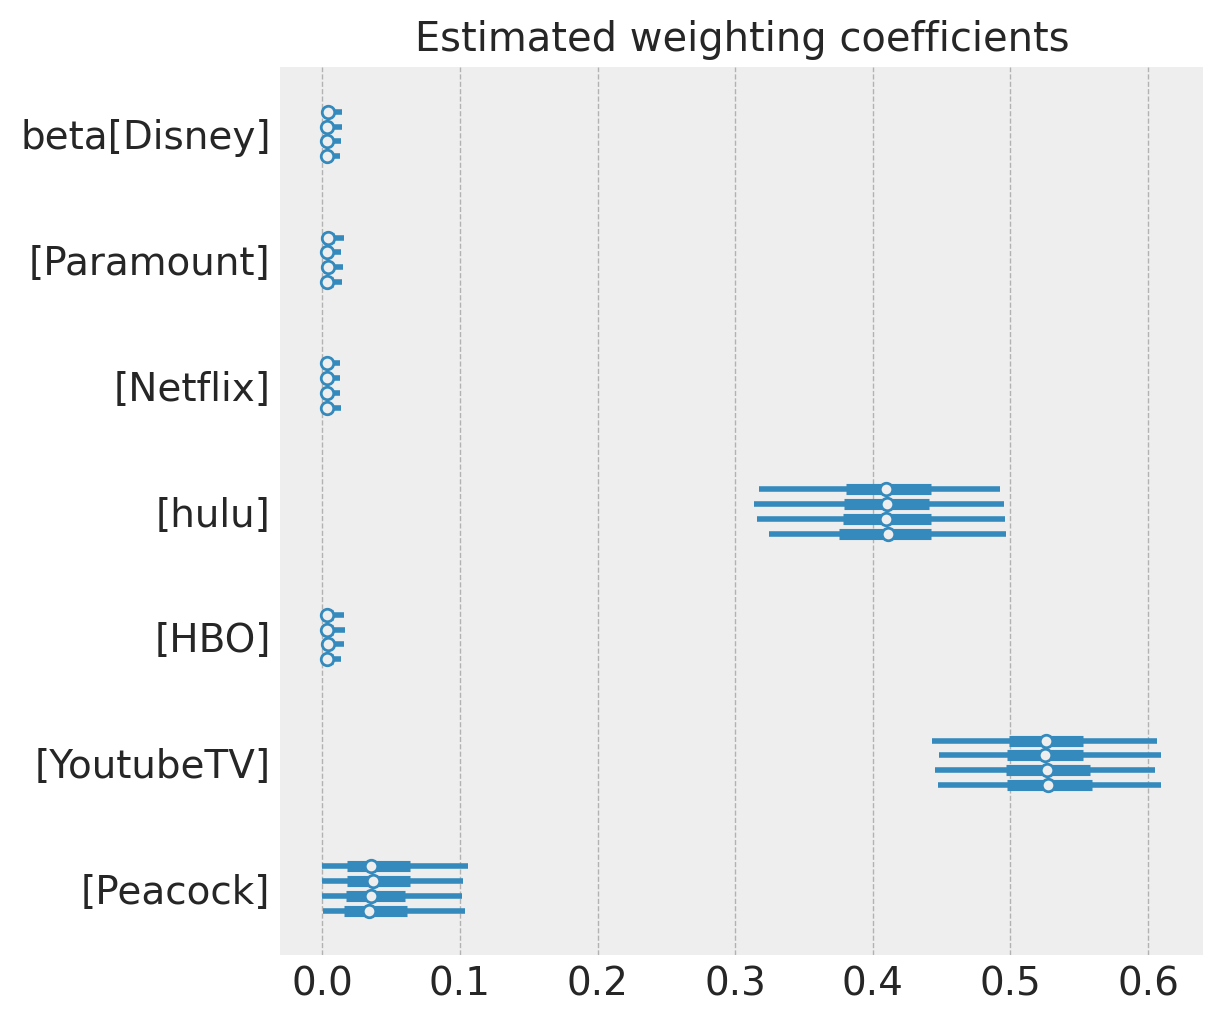

In [8]:
ax = az.plot_forest(results.idata, var_names="beta", figsize=(6, 5))
ax[0].set(title="Estimated weighting coefficients");

We can confirm that the weights satisfy the constraints: they are all positive and add up to one.

Lets take a look at confidence intervals for this estimates:

In [9]:
results.summary()

===============================Synthetic Control================================
Formula: AppleTV ~ 0 + Disney + Paramount + Netflix + hulu + HBO + YoutubeTV + Peacock
Model coefficients:
Disney                        0.01, 94% HDI [0.00, 0.02]
Paramount                     0.01, 94% HDI [0.00, 0.02]
Netflix                       0.00, 94% HDI [0.00, 0.02]
hulu                          0.41, 94% HDI [0.32, 0.50]
HBO                           0.01, 94% HDI [0.00, 0.02]
YoutubeTV                     0.53, 94% HDI [0.45, 0.61]
Peacock                       0.04, 94% HDI [0.00, 0.12]
sigma                         10.93, 94% HDI [10.09, 11.82]


Note that a couple of the 94% highest density intervals (HDIs) contains zero, suggesting that not all predictors were significant. 
**Highest density intervals** have a slightly different interpretation compared to confidence intervals encountered in classical (frequentist) statistics. An HDI provides a range where the parameter is most likely to be, given the data and the model. A confidence interval, on the other hand, provides a range of values that, over repeated sampling, would contain the true parameter a certain percentage of the time.

# Summary of Causal Impact

Now, lets plot the results.

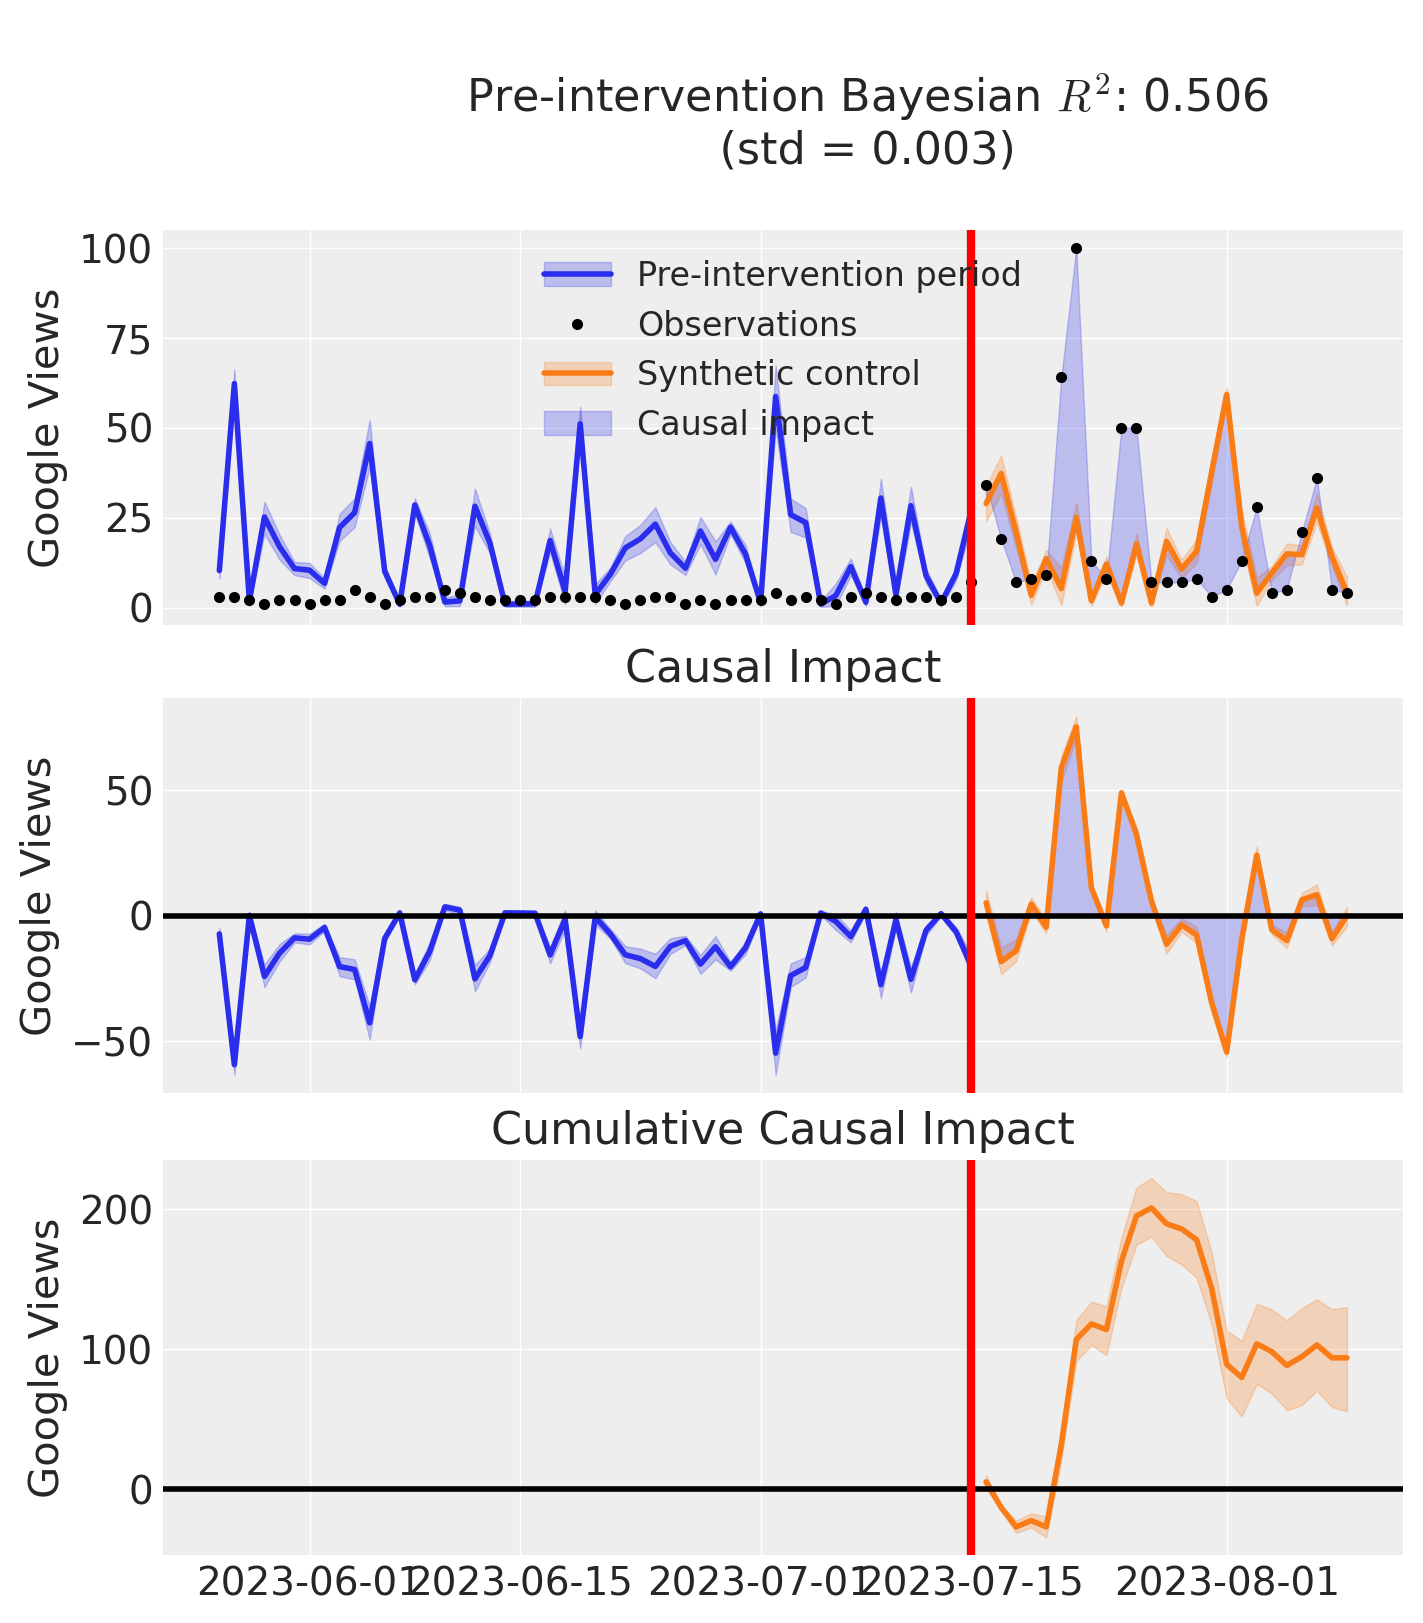

In [10]:
az.style.use("arviz-darkgrid")

fig, ax = results.plot(plot_predictors=False)

for i in [0, 1, 2]:
    ax[i].set(ylabel="Google Views")

plt.show()

From a first glance at the initial graph, there's notable noise, which raises concerns about the synthetic control's ability to construct the treated unit (*AppleTV*) before the intervention. Yet, the Bayesian R^2 value for pre-treatment data is 0.506. Although it isn't perfect, it is a reasonable value.

Now let's examine the causal impact. We can start by plotting the posterior distribution of the cumulative causal impact.

/Users/axelaguerreberry/anaconda3/lib/python3.11/site-packages/arviz/utils.py:185: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


[Text(0.5, 1.0, 'Estimated cumulative causal impact'),
 Text(0.5, 0, 'Google Views')]

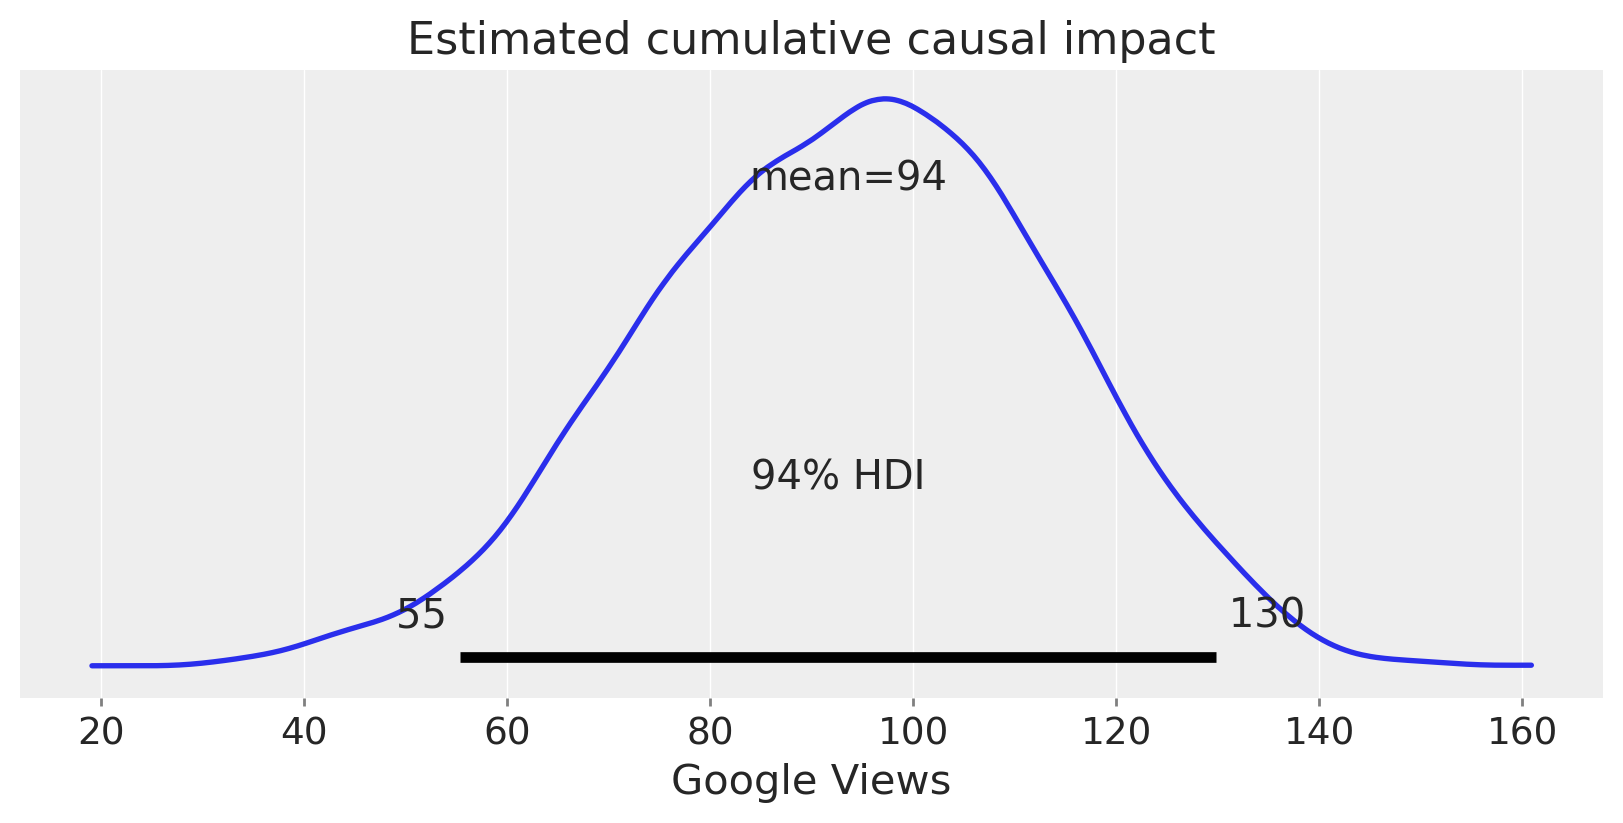

In [11]:
index = results.post_impact_cumulative.obs_ind.max()

last_cumulative_estimate = results.post_impact_cumulative.sel({"obs_ind": index})

ax = az.plot_posterior(last_cumulative_estimate, figsize=(8, 4))
ax.set(
    title="Estimated cumulative causal impact",
    xlabel="Google Views",
)

We can extract the mean and standard deviation of this distribution:

In [12]:
az.summary(last_cumulative_estimate, kind="stats")

,mean,sd,hdi_3%,hdi_97%
x,93.616,20.168,55.339,129.795


Our estimated cumulative causal impact is 93, with a 94% confidence interval ranging from 55 to 130. This means that the intervention – Messi's announcement – resulted in an additional 93 Google views for *AppleTV*, which can be attributed to this specific intervention.

You might be curious about the average daily causal impact during the post-intervention period. We can calculate this the following way:

In [13]:
az.summary(results.post_impact.mean("obs_ind"))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,3.745,0.807,2.214,5.192,0.013,0.01,3538.0,2964.0,1.0


However, it's crucial to approach the mean impact statistic with caution. It's meaningful only when the intervention appears to have a sustained and fairly consistent effect on the outcome.
If the impact is short-lived, then much of the post-intervention period might show the effect diminishing.

Indeed, if we observe the cumulative causal impact graph, it's evident that the effect starts off strong but gradually diminishes over time.

## Choosing the right donor pool

It is recommended to use synthetic controls only if the pre-treatment fit is almost perfect. In our analysis the R2 value was far from being perfect. So, how could we improve this?

One key aspect to consider is the donor pool: the credibility of a synthetic control estimator depends largely on its ability to track the trajectory of the outcome variable for the treated unit in the pre-intervention period.
Many practitioners would recommend using at least between 5 to 25 variables.
At the same time, 
scenarios with a short pre-intervention period, a large donor pool and large noise create substantial risk of overfitting.
That is why, it is recommended to select controls units that have similar trajectory compared to the treated unit in the pre-intervention period in order to reduce interpolation biases and risk of overfitting.

## How Can We Increase Our Confidence in This Method?

[Abadie, Diamond, and Hainmueller (2010)](https://www.tandfonline.com/doi/abs/10.1198/jasa.2009.ap08746) introduced an approach that incorporates permutation techniques to the synthetic control estimator.

Basically, the effect on the intervention is estimated separately for each of the units in the donor pool.
The permutation distribution is obtained by iteratively reassigning the treatment to the units in the donor pool and estimating “placebo effects” in each iteration.
Then, the permutation distribution is constructed by pooling the effect estimated for the treated unit together with placebo effects estimated for the units in the donor pool.
Onece we have the effect for each unit, we check if the treatment effect in *AppleTV* is sufficiently larger when compared to the other fake treatment. 

Let's implement the code for this part. We need to fit the *SyntheticControl()* class as we did above but one time for each streaming platform in our donor pool. We will parallelize this computation using the *joblib* python package.

Once again checkout [Chapter 15 of Matheus Facure online book](https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html#making-inference) for more details on this part.

In [14]:
donor_data = pd.DataFrame(
    {
        "AppleTV": [df.AppleTV.values],
        "Disney": [df.Disney.values],
        "Paramount": [df.Paramount.values],
        "Netflix": [df.Netflix.values],
        "hulu": [df.hulu.values],
        "HBO": [df.HBO.values],
        "YoutubeTV": [df.YoutubeTV.values],
        "Peacock": [df.Peacock.values],
    }
)

all_platforms = control_platforms.copy()
all_platforms.append(target_platform)

In [ ]:
def compute_unit_result(treated_unit, donor_data, df, treatment_index, seed):
    donor_data_for_treated = donor_data.drop(columns=[treated_unit])
    treatment_data = donor_data[[treated_unit]]

    formula = f"{treated_unit} ~ 0 + {' + '.join(donor_data_for_treated.columns)}"
    model = cp.pymc_models.WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    )
    results = cp.pymc_experiments.SyntheticControl(
        df, treatment_index, formula=formula, model=model
    )

    pre_mean = results.pre_impact.mean(dim=["chain", "draw"]).values
    post_mean = results.post_impact.mean(dim=["chain", "draw"]).values

    return {"treated_unit": treated_unit, "pre_mean": pre_mean, "post_mean": post_mean}


all_platforms = donor_data.columns.tolist()

results_df = Parallel(n_jobs=2)(
    delayed(compute_unit_result)(treated_unit, donor_data, df, treatment_index, seed)
    for treated_unit in all_platforms
)

results_df = pd.DataFrame(results_df)

After completing this calculation, let's visualize these time series on a plot.

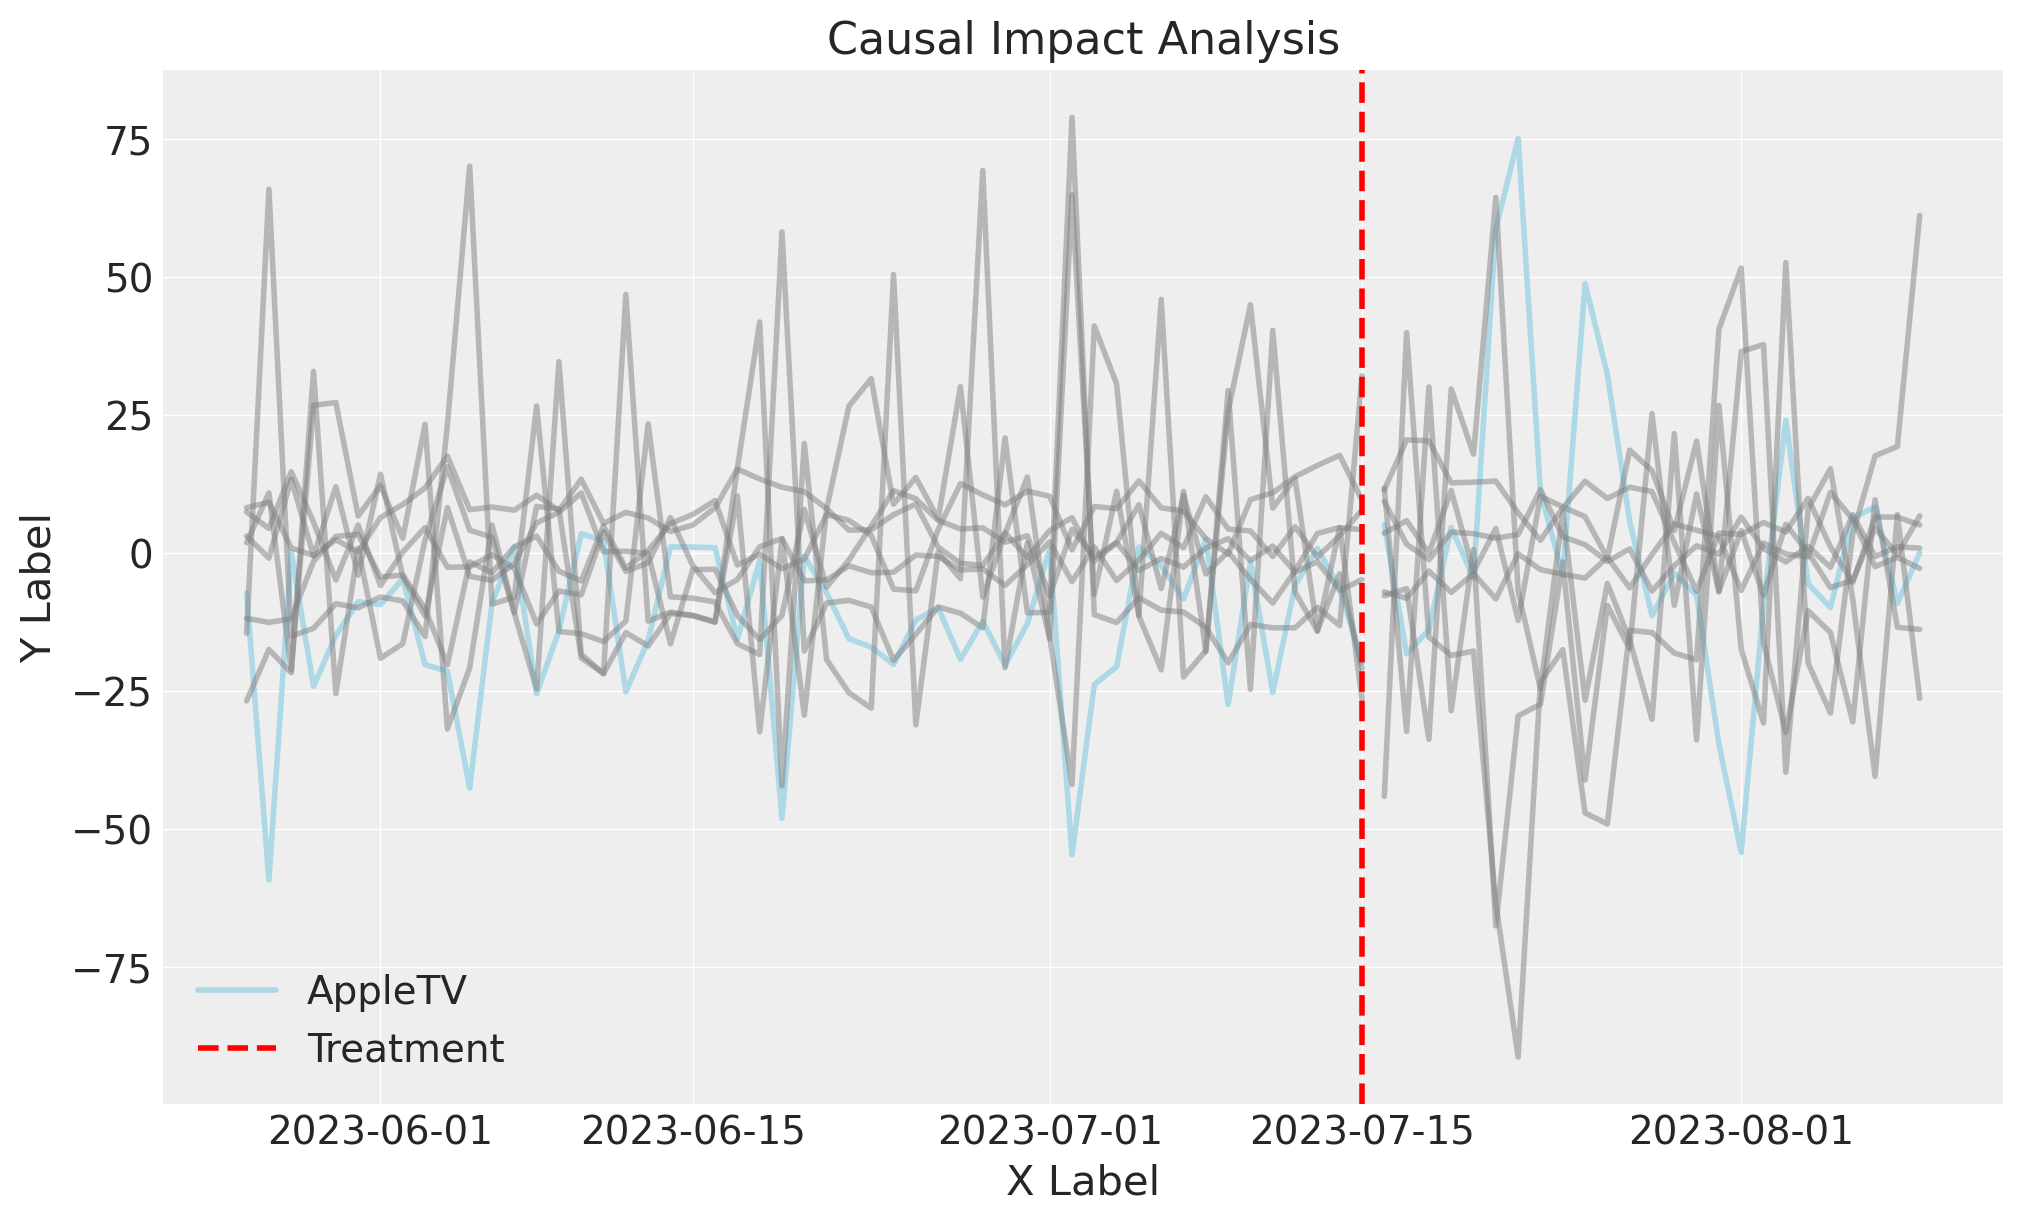

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

for index, row in results_df.iterrows():
    treated_unit = row["treated_unit"]
    pre_mean = row["pre_mean"]
    post_mean = row["post_mean"]

    if treated_unit == "AppleTV":
        ax.plot(
            results.datapre.index,
            pre_mean,
            color="lightblue",
            label=f"{treated_unit}",
        )
        ax.plot(
            results.datapost.index,
            post_mean,
            color="lightblue",
        )
    else:
        ax.plot(
            results.datapre.index,
            pre_mean,
            color="grey",
            alpha=0.5,
        )
        ax.plot(
            results.datapost.index,
            post_mean,
            color="grey",
            alpha=0.5,
        )

ax.axvline(x=treatment_index, color="red", linestyle="--", label="Treatment")
ax.set_xlabel("X Label")
ax.set_ylabel("Y Label")
ax.set_title("Causal Impact Analysis")
ax.legend()
plt.show()

From the graph, we notice that the effect for *AppleTV* is quite extreme, at least right after the intervention, but it is not so clear.
Lets explore this a little bit more. We'll begin by examining the mean causal effect:

In [17]:
results_df["mean_causal_effect"] = results_df["post_mean"].apply(lambda x: sum(x))

apple_tv_effect = results_df[results_df["treated_unit"] == "AppleTV"][
    "mean_causal_effect"
].values

other_effects = results_df[results_df["treated_unit"] != "AppleTV"][
    "mean_causal_effect"
].values


We can estimate the P-value as the proportion of times the effect of *AppleTV* is lower than all the other estimated effects.

$
PV=\frac{1}{N}\sum \mathcal{1}\{\hat{\tau}_{AppleTV} < \hat{\tau}_j\}
$

In [18]:
np.mean(np.array(other_effects) > apple_tv_effect)

0.14285714285714285

As we can observe, out of the 8 placebo effects we've estimated only one is higher than the effect we found in *AppleTV*.

We can see that for *Disney* we get a higher causal effect compared to *AppleTv*:

In [19]:
results_df[["treated_unit", "mean_causal_effect"]]

,treated_unit,mean_causal_effect
0,AppleTV,93.616135
1,Disney,188.946138
2,Paramount,85.889066
3,Netflix,-39.452526
4,hulu,-203.766938
5,HBO,42.346223
6,YoutubeTV,-443.547799
7,Peacock,32.895885


But wait, is *Disney* even a good fit?

Lets add to our analysis the MSE in the **preintervention period**:

$
MSE = \frac{1}{N}\sum\bigg(Y_t - \hat{Y}^{Synth}_t\bigg)^2
$

In [20]:
def pre_treatment_mse(data, treated_unit_column, pre_mean_value):
    pre_treat_error = (data[treated_unit_column] - pre_mean_value) ** 2
    return pre_treat_error.mean()


mse_results = []

for index, row in results_df.iterrows():
    treated_unit = row["treated_unit"]
    pre_mean = row["pre_mean"]

    mse = pre_treatment_mse(df[df.index <= treatment_index], treated_unit, pre_mean)
    mse_results.append(mse)

results_df["pre_treatment_mse"] = mse_results

In [21]:
results_df[["treated_unit", "mean_causal_effect", "pre_treatment_mse"]]

,treated_unit,mean_causal_effect,pre_treatment_mse
0,AppleTV,93.616135,473.361314
1,Disney,188.946138,3765.544794
2,Paramount,85.889066,3490.741808
3,Netflix,-39.452526,3661.864899
4,hulu,-203.766938,434.463647
5,HBO,42.346223,3604.316183
6,YoutubeTV,-443.547799,171.313767
7,Peacock,32.895885,636.029627


We note that the MSE (during the pre-intervention period) for *Disney* is significantly high, indicating it is a bad fit. One good idea is to remove units with high error.
In fact, [Abadie, Diamond, and Hainmueller (2010)](https://www.tandfonline.com/doi/abs/10.1198/jasa.2009.ap08746) suggests removing units for which the MSE is two times higher than the MSE of the treated unit.
Using this guideline, *AppleTV* stands out as the unit with the highest (or more extreme) value of treatment effect.

## Final Thougts

In this article, we have explore a very popular quasi-experimental method using the CausalPy python package. When A/B testing is not always feasible, the synthetic control method presents an alternative that requires substantially less effort. 
A primary advantage of synthetic controls, which is particularly attractive to machine learning practitioners, is its interpretability.
Synthetic controls make explicit the contribution of each comparison unit to the counterfactual of interest, since it avoids extrapolaiton and weights are nonnegative and sum up to one.

For additional resources on Synthetic Controls, check out [Using Synthetic Controls: Feasibility, Data Requirements, and Methodological Aspects (2021)](https://www.aeaweb.org/articles?id=10.1257/jel.20191450).

We have covered the basics of synthetic controls, but there have been some extensions recently, for example [incorporating multiple outcome variables](https://arxiv.org/pdf/2304.02272.pdf) and the [synthetic difference-in-differences](https://arxiv.org/pdf/1610.07748.pdf).

## References

[1] A. Abadie, A. Diamond, and J. Hainmueller, [Synthetic Control Methods for Comparative Case Studies: Estimating the Effect of California’s Tobacco Control Program (2010)](https://www.tandfonline.com/doi/abs/10.1198/jasa.2009.ap08746), Journal of the American Statistical Association.

[2] A. Abadie, [Using Synthetic Controls: Feasibility, Data Requirements, and Methodological Aspects (2021)](https://www.aeaweb.org/articles?id=10.1257/jel.20191450), Journal of Economic Perspectives.

[3] M. Facure, [Chapter 15 of Causal Inference for the Brave and True](https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html).

[4] A. Molak, [Causal Inference and Discovery in Python: Unlock the secrets of modern causal machine learning with DoWhy, EconML, PyTorch and more.
](https://www.amazon.com/Causal-Inference-Discovery-Python-learning/dp/1804612987#:~:text=Causal%20Inference%20and%20Discovery%20in%20Python%20helps%20you%20unlock%20the,interventions%2C%20counterfactuals%2C%20and%20more.)

[5] M. Courthoud, [Understanding Synthetic Control Methods](https://towardsdatascience.com/understanding-synthetic-control-methods-dd9a291885a1), Towards Data Science.